# 个人收入预测模型建立

## 导入库

### 导入基本库

In [1]:
import os,math,random,requests,types, time, datetime,subprocess

### 导入第三方库

In [2]:
# 数据处理
import numpy as np
import pandas as pd

# 数据可视化
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

# 特征选择和编码
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# 机器学习
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# 网格搜索、随机搜索
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# 模型度量（分类）
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

# 警告处理 
import warnings
warnings.filterwarnings('ignore')

# 在Jupyter上画图
%matplotlib inline

## 目标

#### 在这个项目中，我们将使用美国人口普查收入数据集，根据人口普查数据预测个人收入是否超过每年50,000美元。

#### 数据集地址: https://archive.ics.uci.edu/ml/datasets/adult

#### 数据分为训练和测试数据集。 我们将两个进行联合数据分析，然后在运行算法之前再将它们分开。

In [3]:
DATA_URLS = [
    'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
    'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names',
    'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
]

def download_data(path = 'dataset',urls = DATA_URLS):
    if not os.path.exists(path):
        os.mkdir(path)
    
    for url in urls:
        response = requests.get(url)
        name = os.path.basename(url)
        with open(os.path.join(path,name),'wb+') as f:
            f.write(response.content)
        print('------',str(urls.index(url)))
        
# download_data() #第一次运行后注销掉

### 加载数据

In [4]:
# 每个字段的名字
names = ['age','workclass',
        'fnlwgt','education',
        'education-num','marital-status',
        'occupation','relationship',
        'race','sex',
        'capital-gain','capital-loss',
        'hours-per-week','native-country','salary']

# 加载测试数据
test_data = pd.read_csv('dataset/adult.test',
                       sep = ',\s',
                       names = names,
                       header = None,
                       engine = 'python',
                       skiprows = 1,
                       na_values = ['?']) # 数据集中是问好的全部转为空

#加载训练数据
train_data = pd.read_csv('dataset/adult.data',
                       sep = ',\s',
                       names = names,
                       header = None,
                       engine = 'python',
                       na_values = ['?'])

test_data.shape  #(16281, 15)

(16281, 15)

### 加测试数据和训练数据加在一起进行数据处理

In [5]:
data_raw = train_data.append(test_data)
data_raw.reset_index(inplace = True)
data_raw.drop('index',inplace=True,axis = 1)
data_raw

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


## 单一变量数据分析
特征类型:
- **数字型:** 可计算.
- **标量型:** 任何包含类别或文本的特征.

In [6]:
# 统计所有的数值型数据,
data_raw.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
# 统计所有的标量型数据,
data_raw.describe(include=['O'])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,salary
count,46043,48842,48842,46033,48842,48842,48842,47985,48842
unique,8,16,7,14,6,5,2,41,4
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,24720


In [8]:
data_raw.head(20)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


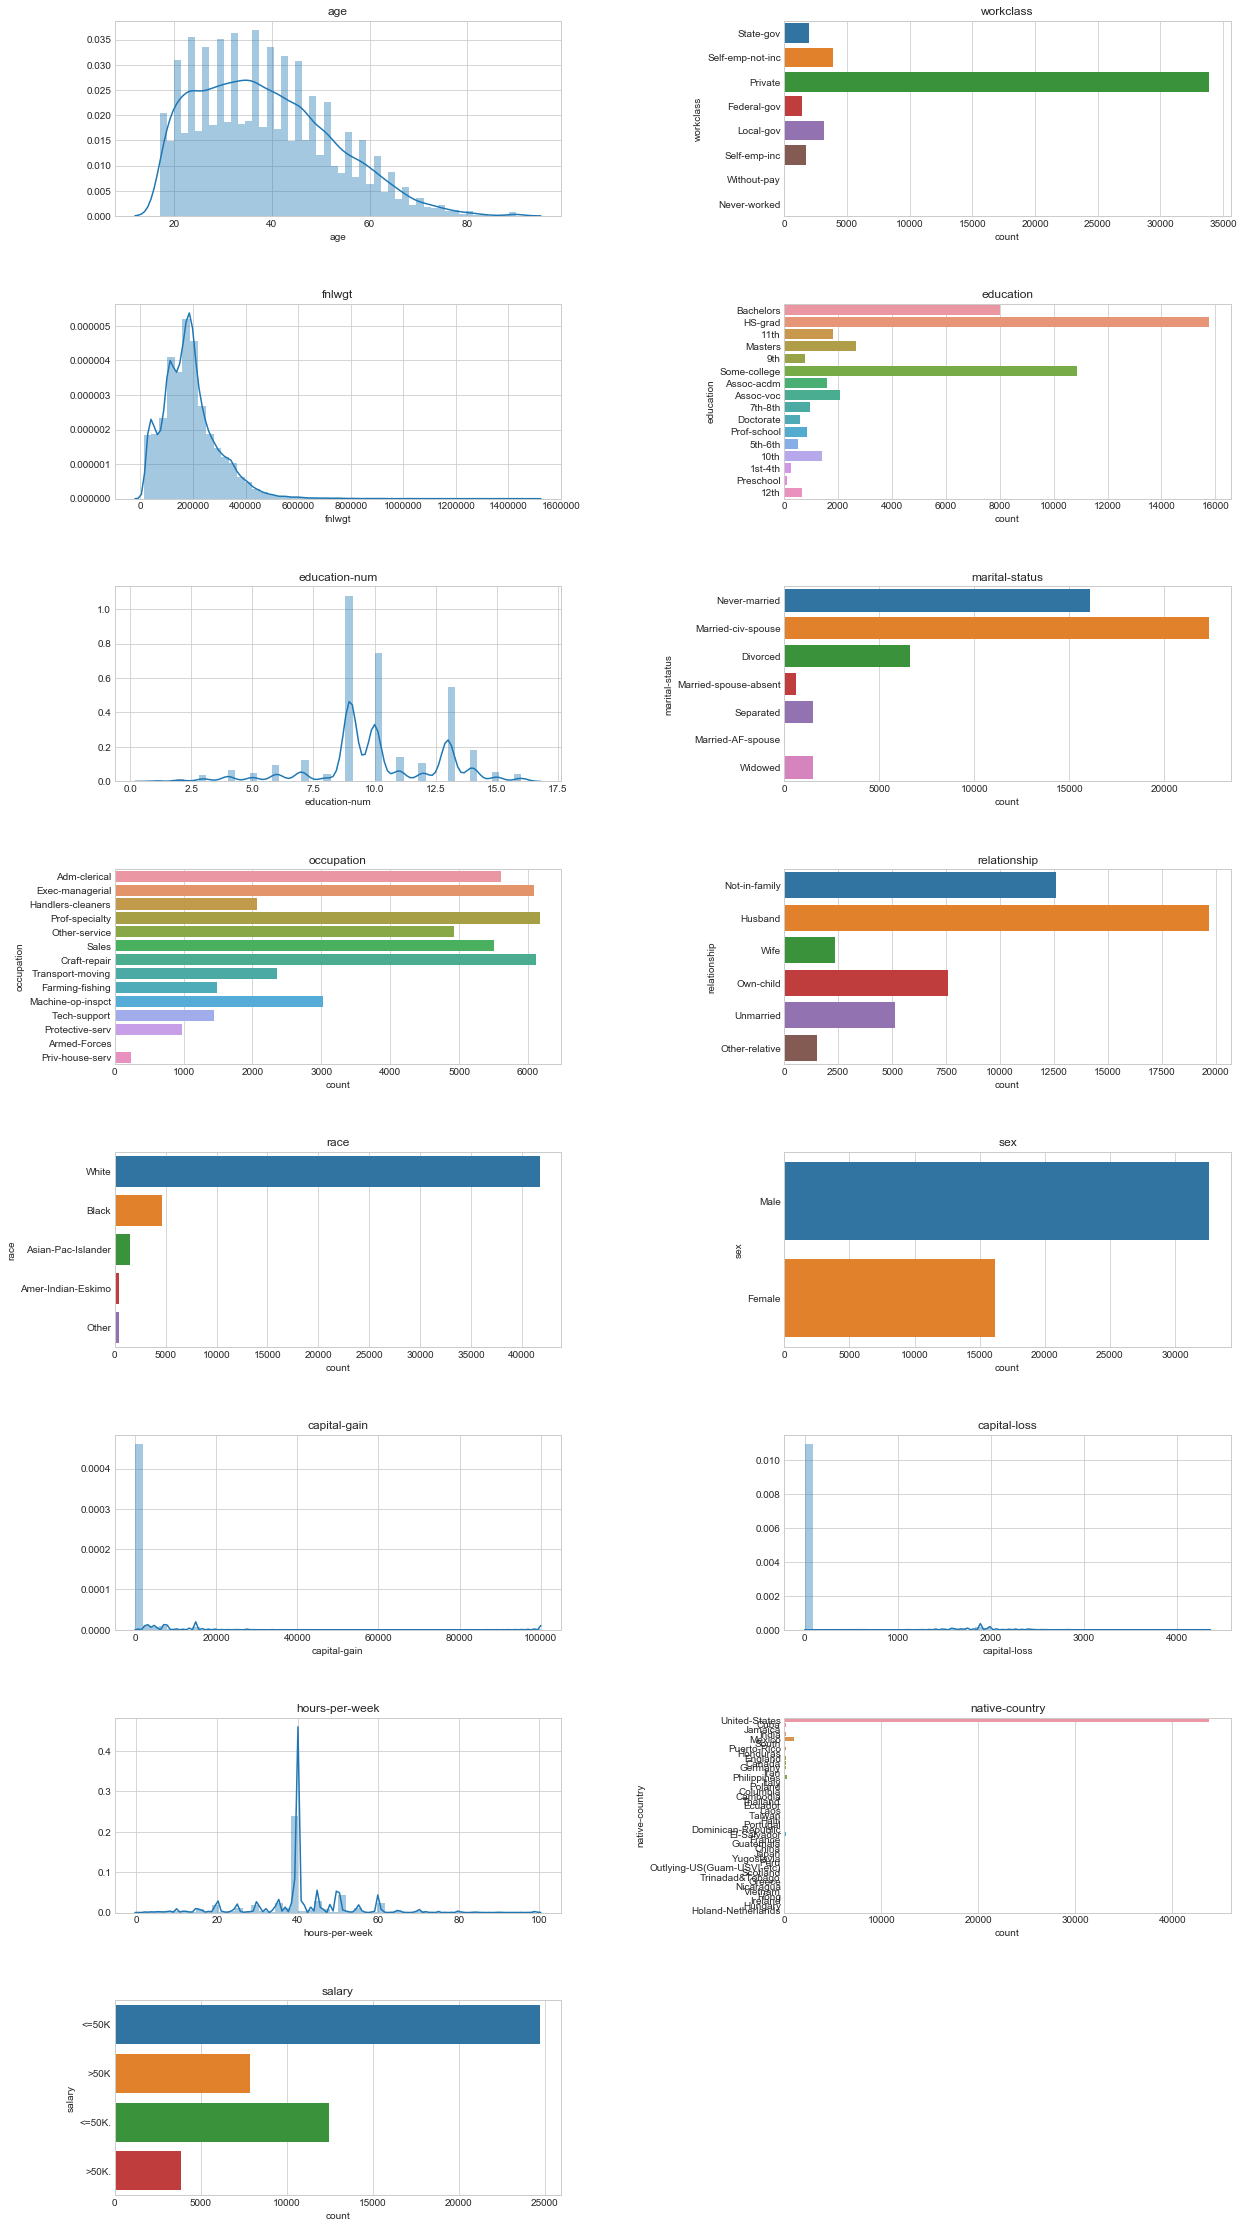

In [9]:
def plot_distribution(data_raw,cols=3, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid') # 设置图的样式
    fig = plt.figure(figsize = (width,height))  # 设置图的大小
    fig.subplots_adjust(wspace=wspace, hspace=hspace) # 设置图之间的间距
    rows = math.ceil(float(data_raw.shape[1]/cols)) #一共有多少行，进一法
    for i, column in enumerate(data_raw.columns):
        ax = fig.add_subplot(rows,cols,i+1) # 再第几个画布上画图
        ax.set_title(column) # 每个表的标题
        
#         if dataset.dtypes[column] == np.object: # 如果是一个多值的，是一个对象使用的绘图方式
        if data_raw.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=data_raw) # 通过seaborn绘图
#             substrings = [s.get_text()[:18] for s in g.get_yticklabels()] # 通过列表推导式将y轴的坐标进行重新剪切，以免过长
#             g.set(yticklabels=substrings) # 将剪切过后的数据重新给予y轴坐标
            plt.xticks(rotation=0) #  设置x轴标签，倾斜角度
        
        else:
            g = sns.distplot(data_raw[column])
            plt.xticks(rotation=0)
    
plot_distribution(data_raw, cols=2, width=20, height=40, hspace=0.45, wspace=0.5)
        

### 查看缺失值

#### 使用missingno可以查看缺失值，显示的白色格子就是表示是缺失值

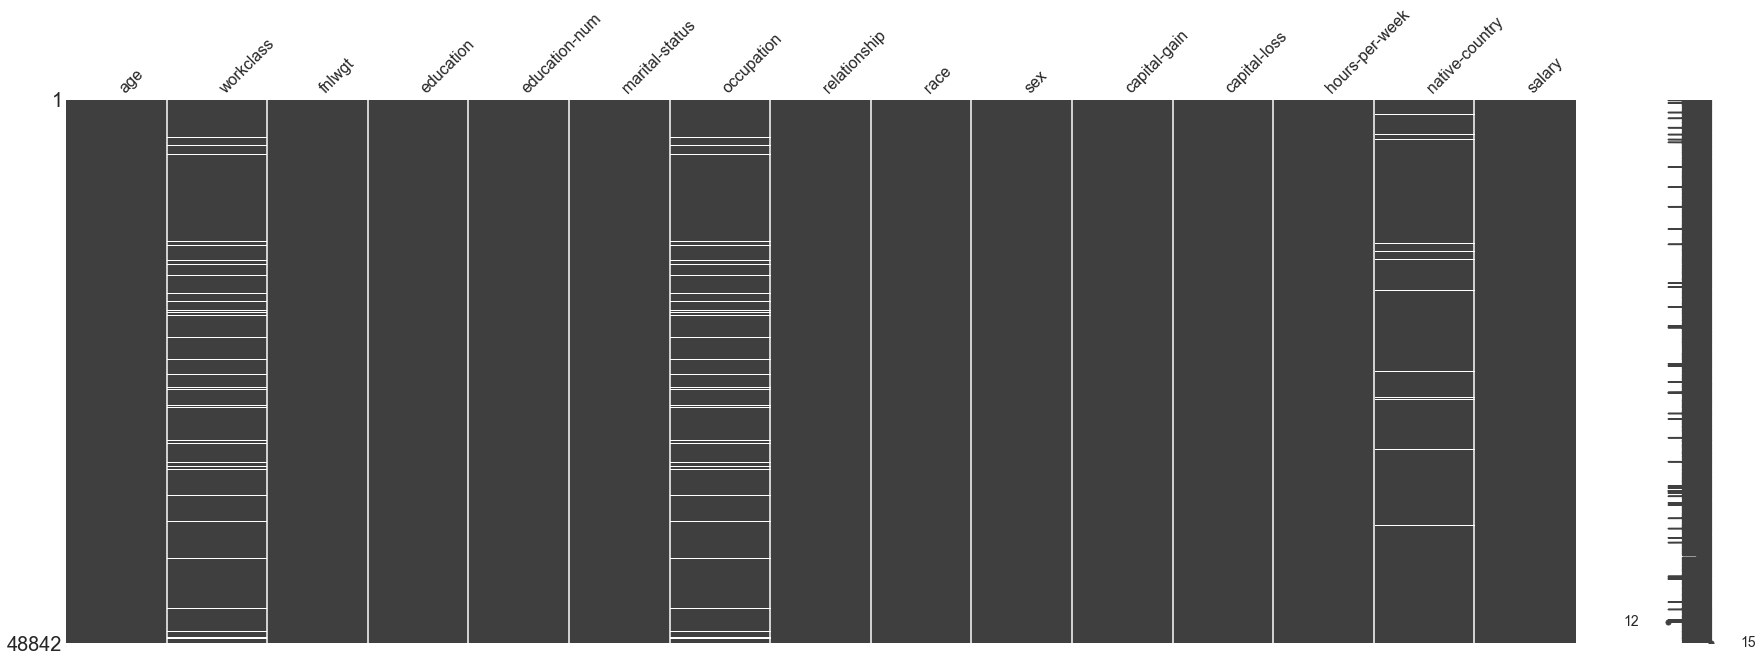

In [10]:
missingno.matrix(data_raw,figsize = (30,10)) # missingno库下面的matrix函数可以绘出缺失值的位置


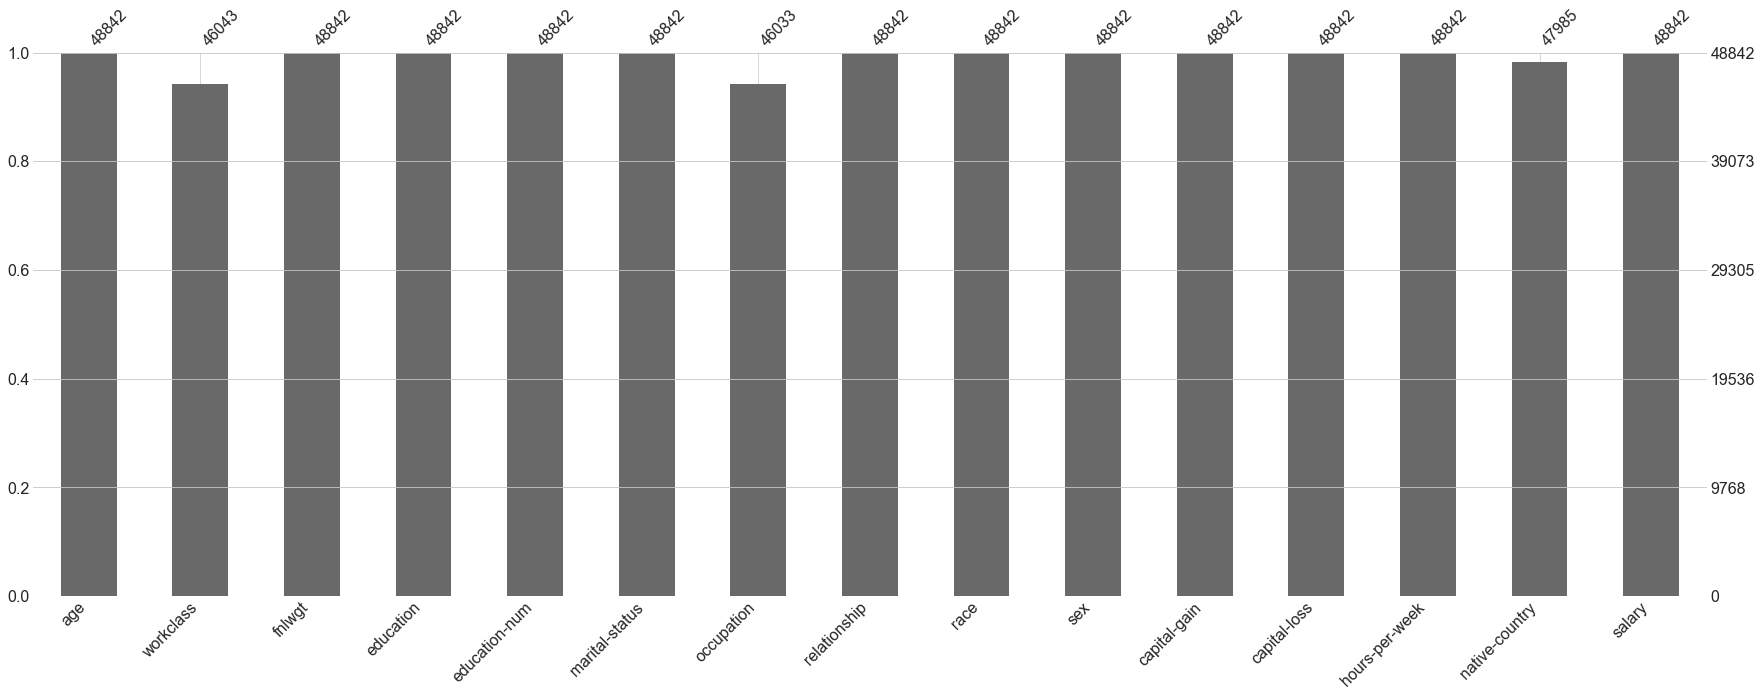

In [11]:
missingno.bar(data_raw,figsize = (30,10),sort = 'ascending') # 将缺失值通过图形展示出来

# 特征清洗、特征工程、缺失值填补

**清洗:**
清洗什么？

- **缺失值:** 去除or填补（方式？）.
- **特殊值:** N±Inf, NA and NaN.
- **奇异值:** 检测，是否去除？
- **不一致性:** 年龄<0，男的怀孕，etc.

**工程:**
方法:
- **分解:** 将2014-09-20T20：45：40Z转换为分类属性，如hour_of_the_day，part_of_day等
- **离散化:** 连续变量离散化，比较算法在连续数据和离散数据上的不同表现. 一些约定:

    - dataset_bin => 连续变量离散化后
    - dataset_con => 连续变量未离散化 

- **数值量级的转化:** 克-->千克，减少了数据细节可能会增加效率
- **特征交叉:** 字段衍生：新字段包好许多别的字段的特征（数字or标量）

**缺失值填补**
方式：
- **均值**
- **中位数** 
- **众数**

### 一个一个的进行处理

### **属性：** salary 
#### 转换为0或者1  大于50k为1 小于等于50k为0

In [12]:
# 创建两个新的DataFrame，一个用于存离散的，一个用于存未离散的
dataset_bin = pd.DataFrame()  # 离散的
dataset_con = pd.DataFrame()  # 未离散的

In [13]:
data_raw.loc[data_raw['salary'] == '>50K.', 'salary'] = 1
data_raw.loc[data_raw['salary'] == '>50K', 'salary'] = 1
data_raw.loc[data_raw['salary'] == '<=50K.', 'salary'] = 0
data_raw.loc[data_raw['salary'] == '<=50K', 'salary'] = 0

dataset_bin['salary'] = data_raw['salary']
dataset_con['salary'] = data_raw['salary']

### 画salary特征的分布图

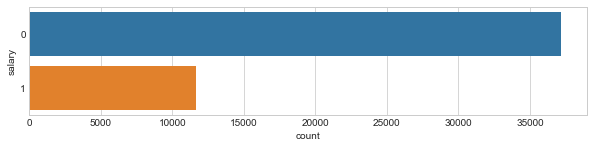

In [14]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (10,2))
sns.countplot(y = 'salary',data = dataset_bin)

### **属性：** age
#### 使用pandas.cut的功能将年龄进行分箱

In [15]:
dataset_bin['age'] = pd.cut(data_raw['age'],10) # 离散化数据赋值,分成10组
dataset_con['age'] = data_raw['age'] # 未离散化数据赋值
dataset_bin.head()

,salary,age
0,0,"(38.9, 46.2]"
1,0,"(46.2, 53.5]"
2,0,"(31.6, 38.9]"
3,0,"(46.2, 53.5]"
4,0,"(24.3, 31.6]"


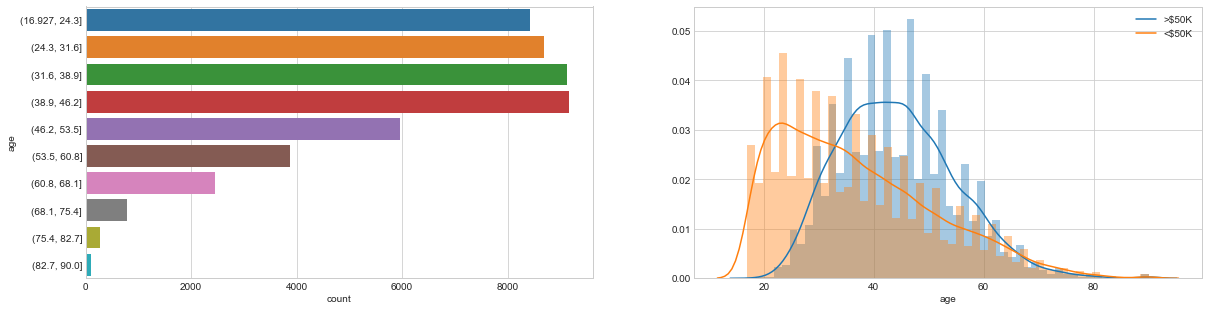

In [16]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5)) 
plt.subplot(1, 2, 1)# 离散后的数据分布直方图
sns.countplot(y="age", data=dataset_bin);

plt.subplot(1, 2, 2)# 未离散的数据分布直方图
# 带趋势线的直方图
sns.distplot(dataset_con.loc[dataset_con['salary'] == 1]['age'], kde_kws={"label": ">$50K"});
sns.distplot(dataset_con.loc[dataset_con['salary'] == 0]['age'], kde_kws={"label": "<$50K"});

### 属性：workclass	

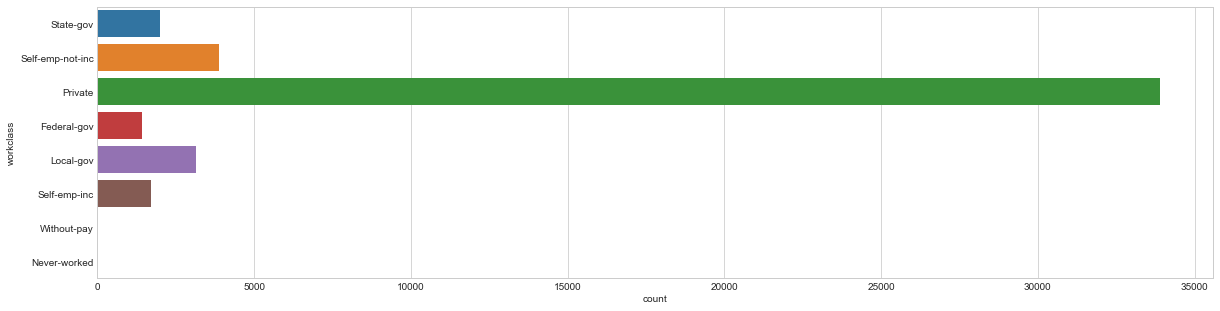

In [17]:
# 属性workclass的分布图
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
sns.countplot(y='workclass',data = data_raw)

#### 减少类别的数量

In [18]:
data_raw.loc[data_raw['workclass'] == 'Without-pay', 'workclass'] = 'Not Working'
data_raw.loc[data_raw['workclass'] == 'Never-worked', 'workclass'] = 'Not Working'
data_raw.loc[data_raw['workclass'] == 'Federal-gov', 'workclass'] = 'Fed-gov'
data_raw.loc[data_raw['workclass'] == 'State-gov', 'workclass'] = 'Non-fed-gov'
data_raw.loc[data_raw['workclass'] == 'Local-gov', 'workclass'] = 'Non-fed-gov'
data_raw.loc[data_raw['workclass'] == 'Self-emp-not-inc', 'workclass'] = 'Self-emp'
data_raw.loc[data_raw['workclass'] == 'Self-emp-inc', 'workclass'] = 'Self-emp'

dataset_bin['workclass'] = data_raw['workclass']
dataset_con['workclass'] = data_raw['workclass']

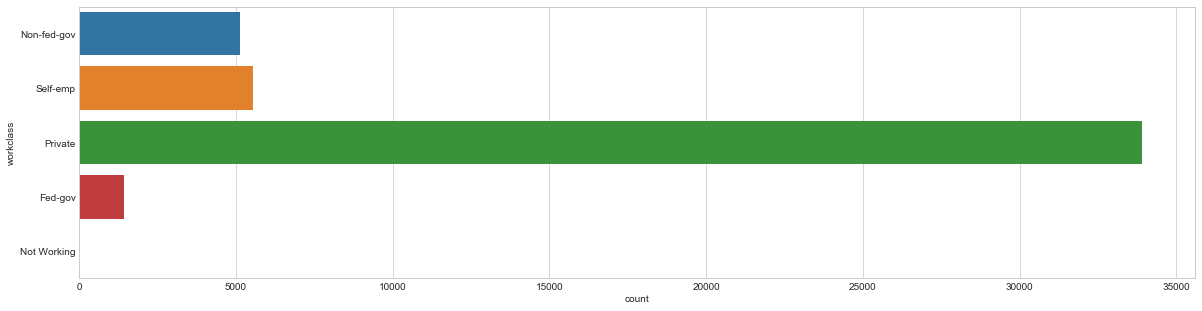

In [19]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
sns.countplot(y = 'workclass', data = dataset_con)

### 属性: Occupation

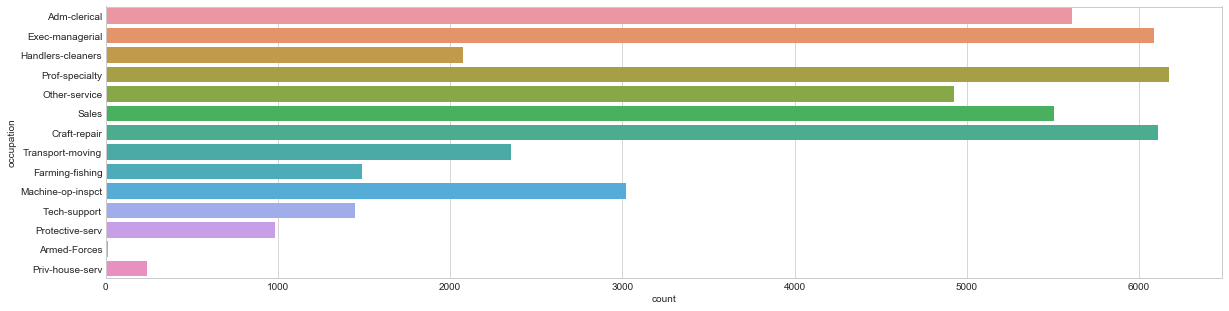

In [20]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
sns.countplot(y="occupation", data=data_raw)

#### 属性融合

In [21]:
data_raw.loc[data_raw['occupation'] == 'Adm-clerical', 'occupation'] = 'Admin'
data_raw.loc[data_raw['occupation'] == 'Armed-Forces', 'occupation'] = 'Military'
data_raw.loc[data_raw['occupation'] == 'Craft-repair', 'occupation'] = 'Manual Labour'
data_raw.loc[data_raw['occupation'] == 'Exec-managerial', 'occupation'] = 'Office Labour'
data_raw.loc[data_raw['occupation'] == 'Farming-fishing', 'occupation'] = 'Manual Labour'
data_raw.loc[data_raw['occupation'] == 'Handlers-cleaners', 'occupation'] = 'Manual Labour'
data_raw.loc[data_raw['occupation'] == 'Machine-op-inspct', 'occupation'] = 'Manual Labour'
data_raw.loc[data_raw['occupation'] == 'Other-service', 'occupation'] = 'Service'
data_raw.loc[data_raw['occupation'] == 'Priv-house-serv', 'occupation'] = 'Service'
data_raw.loc[data_raw['occupation'] == 'Prof-specialty', 'occupation'] = 'Professional'
data_raw.loc[data_raw['occupation'] == 'Protective-serv', 'occupation'] = 'Military'
data_raw.loc[data_raw['occupation'] == 'Sales', 'occupation'] = 'Office Labour'
data_raw.loc[data_raw['occupation'] == 'Tech-support', 'occupation'] = 'Office Labour'
data_raw.loc[data_raw['occupation'] == 'Transport-moving', 'occupation'] = 'Manual Labour'

dataset_bin['occupation'] = data_raw['occupation']
dataset_con['occupation'] = data_raw['occupation']

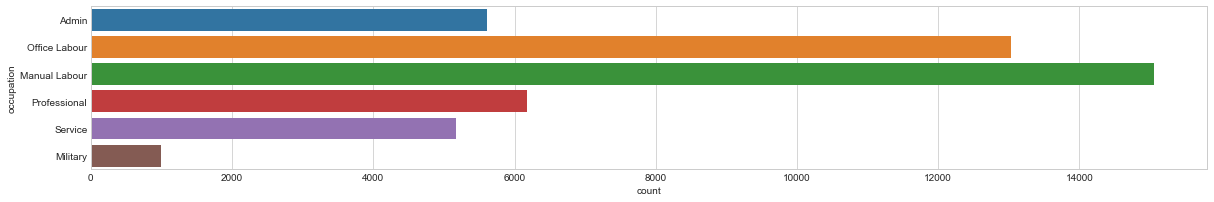

In [22]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3))
sns.countplot(y="occupation", data=dataset_bin)

### 属性: Native Country

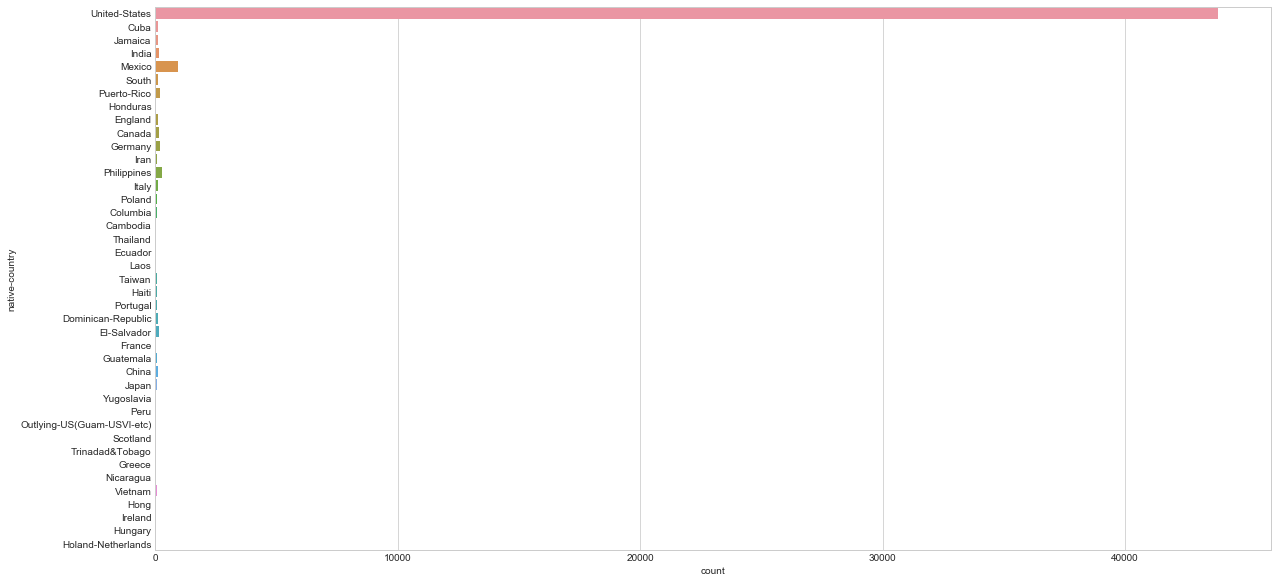

In [23]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,10)) 
sns.countplot(y="native-country", data=data_raw);

In [24]:
data_raw.loc[data_raw['native-country'] == 'Cambodia'                    , 'native-country'] = 'SE-Asia'
data_raw.loc[data_raw['native-country'] == 'Canada'                      , 'native-country'] = 'British-Commonwealth'    
data_raw.loc[data_raw['native-country'] == 'China'                       , 'native-country'] = 'China'       
data_raw.loc[data_raw['native-country'] == 'Columbia'                    , 'native-country'] = 'South-America'    
data_raw.loc[data_raw['native-country'] == 'Cuba'                        , 'native-country'] = 'South-America'        
data_raw.loc[data_raw['native-country'] == 'Dominican-Republic'          , 'native-country'] = 'South-America'
data_raw.loc[data_raw['native-country'] == 'Ecuador'                     , 'native-country'] = 'South-America'     
data_raw.loc[data_raw['native-country'] == 'El-Salvador'                 , 'native-country'] = 'South-America' 
data_raw.loc[data_raw['native-country'] == 'England'                     , 'native-country'] = 'British-Commonwealth'
data_raw.loc[data_raw['native-country'] == 'France'                      , 'native-country'] = 'Euro_Group_1'
data_raw.loc[data_raw['native-country'] == 'Germany'                     , 'native-country'] = 'Euro_Group_1'
data_raw.loc[data_raw['native-country'] == 'Greece'                      , 'native-country'] = 'Euro_Group_2'
data_raw.loc[data_raw['native-country'] == 'Guatemala'                   , 'native-country'] = 'South-America'
data_raw.loc[data_raw['native-country'] == 'Haiti'                       , 'native-country'] = 'South-America'
data_raw.loc[data_raw['native-country'] == 'Holand-Netherlands'          , 'native-country'] = 'Euro_Group_1'
data_raw.loc[data_raw['native-country'] == 'Honduras'                    , 'native-country'] = 'South-America'
data_raw.loc[data_raw['native-country'] == 'Hong'                        , 'native-country'] = 'China'
data_raw.loc[data_raw['native-country'] == 'Hungary'                     , 'native-country'] = 'Euro_Group_2'
data_raw.loc[data_raw['native-country'] == 'India'                       , 'native-country'] = 'British-Commonwealth'
data_raw.loc[data_raw['native-country'] == 'Iran'                        , 'native-country'] = 'Euro_Group_2'
data_raw.loc[data_raw['native-country'] == 'Ireland'                     , 'native-country'] = 'British-Commonwealth'
data_raw.loc[data_raw['native-country'] == 'Italy'                       , 'native-country'] = 'Euro_Group_1'
data_raw.loc[data_raw['native-country'] == 'Jamaica'                     , 'native-country'] = 'South-America'
data_raw.loc[data_raw['native-country'] == 'Japan'                       , 'native-country'] = 'APAC'
data_raw.loc[data_raw['native-country'] == 'Laos'                        , 'native-country'] = 'SE-Asia'
data_raw.loc[data_raw['native-country'] == 'Mexico'                      , 'native-country'] = 'South-America'
data_raw.loc[data_raw['native-country'] == 'Nicaragua'                   , 'native-country'] = 'South-America'
data_raw.loc[data_raw['native-country'] == 'Outlying-US(Guam-USVI-etc)'  , 'native-country'] = 'South-America'
data_raw.loc[data_raw['native-country'] == 'Peru'                        , 'native-country'] = 'South-America'
data_raw.loc[data_raw['native-country'] == 'Philippines'                 , 'native-country'] = 'SE-Asia'
data_raw.loc[data_raw['native-country'] == 'Poland'                      , 'native-country'] = 'Euro_Group_2'
data_raw.loc[data_raw['native-country'] == 'Portugal'                    , 'native-country'] = 'Euro_Group_2'
data_raw.loc[data_raw['native-country'] == 'Puerto-Rico'                 , 'native-country'] = 'South-America'
data_raw.loc[data_raw['native-country'] == 'Scotland'                    , 'native-country'] = 'British-Commonwealth'
data_raw.loc[data_raw['native-country'] == 'South'                       , 'native-country'] = 'Euro_Group_2'
data_raw.loc[data_raw['native-country'] == 'Taiwan'                      , 'native-country'] = 'China'
data_raw.loc[data_raw['native-country'] == 'Thailand'                    , 'native-country'] = 'SE-Asia'
data_raw.loc[data_raw['native-country'] == 'Trinadad&Tobago'             , 'native-country'] = 'South-America'
data_raw.loc[data_raw['native-country'] == 'United-States'               , 'native-country'] = 'United-States'
data_raw.loc[data_raw['native-country'] == 'Vietnam'                     , 'native-country'] = 'SE-Asia'
data_raw.loc[data_raw['native-country'] == 'Yugoslavia'                  , 'native-country'] = 'Euro_Group_2'

dataset_bin['native-country'] = data_raw['native-country']
dataset_con['native-country'] = data_raw['native-country']

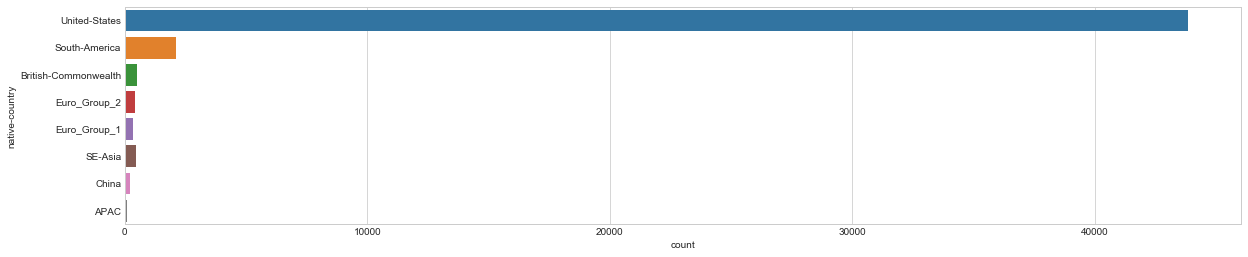

In [25]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.countplot(y="native-country", data=dataset_bin)

### 属性: Education

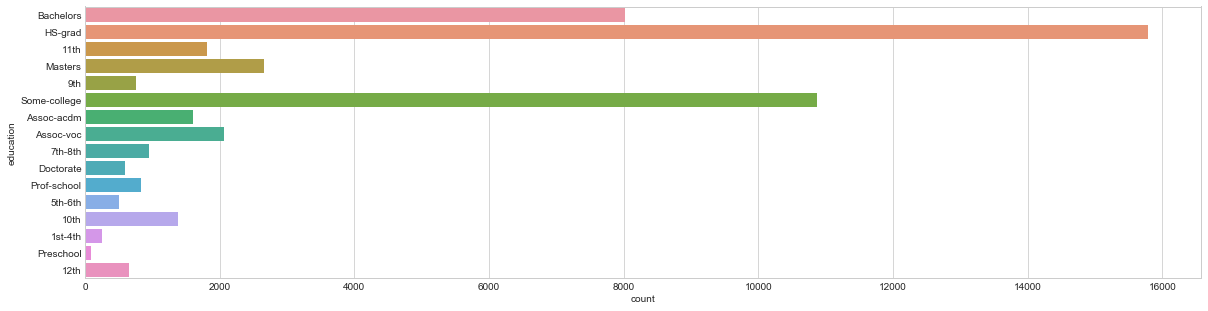

In [26]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
sns.countplot(y="education", data=data_raw)

In [27]:
data_raw.loc[data_raw['education'] == '10th'          , 'education'] = 'Dropout'
data_raw.loc[data_raw['education'] == '11th'          , 'education'] = 'Dropout'
data_raw.loc[data_raw['education'] == '12th'          , 'education'] = 'Dropout'
data_raw.loc[data_raw['education'] == '1st-4th'       , 'education'] = 'Dropout'
data_raw.loc[data_raw['education'] == '5th-6th'       , 'education'] = 'Dropout'
data_raw.loc[data_raw['education'] == '7th-8th'       , 'education'] = 'Dropout'
data_raw.loc[data_raw['education'] == '9th'           , 'education'] = 'Dropout'
data_raw.loc[data_raw['education'] == 'Assoc-acdm'    , 'education'] = 'Associate'
data_raw.loc[data_raw['education'] == 'Assoc-voc'     , 'education'] = 'Associate'
data_raw.loc[data_raw['education'] == 'Bachelors'     , 'education'] = 'Bachelors'
data_raw.loc[data_raw['education'] == 'Doctorate'     , 'education'] = 'Doctorate'
data_raw.loc[data_raw['education'] == 'HS-Grad'       , 'education'] = 'HS-Graduate'
data_raw.loc[data_raw['education'] == 'Masters'       , 'education'] = 'Masters'
data_raw.loc[data_raw['education'] == 'Preschool'     , 'education'] = 'Dropout'
data_raw.loc[data_raw['education'] == 'Prof-school'   , 'education'] = 'Professor'
data_raw.loc[data_raw['education'] == 'Some-college'  , 'education'] = 'HS-Graduate'

dataset_bin['education'] = data_raw['education']
dataset_con['education'] = data_raw['education']

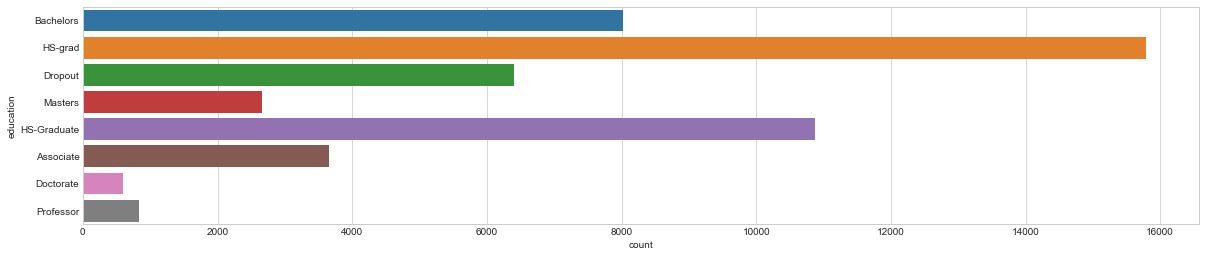

In [28]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.countplot(y="education", data=dataset_bin)

### 属性: Marital Status

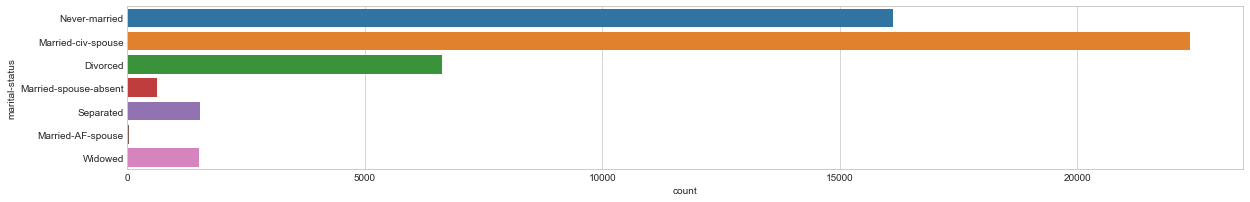

In [29]:
plt.figure(figsize=(20,3)) 
sns.countplot(y="marital-status", data=data_raw);

In [30]:
data_raw.loc[data_raw['marital-status'] == 'Never-married'        , 'marital-status'] = 'Never-Married'
data_raw.loc[data_raw['marital-status'] == 'Married-AF-spouse'    , 'marital-status'] = 'Married'
data_raw.loc[data_raw['marital-status'] == 'Married-civ-spouse'   , 'marital-status'] = 'Married'
data_raw.loc[data_raw['marital-status'] == 'Married-spouse-absent', 'marital-status'] = 'Not-Married'
data_raw.loc[data_raw['marital-status'] == 'Separated'            , 'marital-status'] = 'Separated'
data_raw.loc[data_raw['marital-status'] == 'Divorced'             , 'marital-status'] = 'Separated'
data_raw.loc[data_raw['marital-status'] == 'Widowed'              , 'marital-status'] = 'Widowed'

dataset_bin['marital-status'] = data_raw['marital-status']
dataset_con['marital-status'] = data_raw['marital-status']

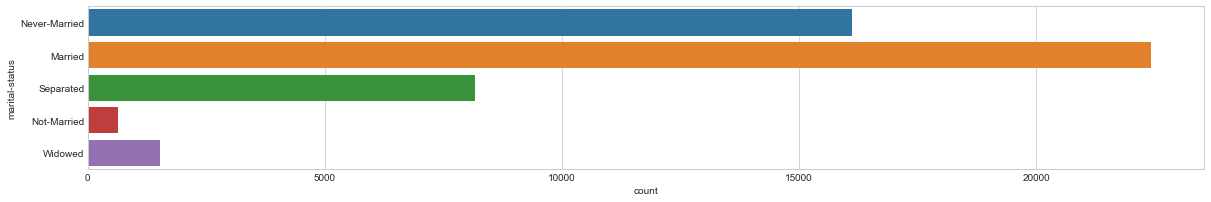

In [31]:
plt.figure(figsize=(20,3)) 
sns.countplot(y="marital-status", data=dataset_bin)

### 属性: Final Weight

In [32]:
dataset_bin['fnlwgt'] = pd.cut(data_raw['fnlwgt'], 10)
dataset_con['fnlwgt'] = data_raw['fnlwgt']

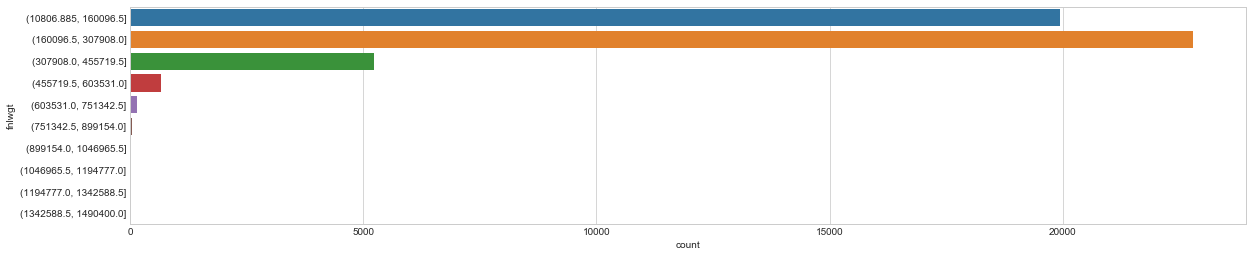

In [33]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
sns.countplot(y="fnlwgt", data=dataset_bin);

### 属性: Education Number

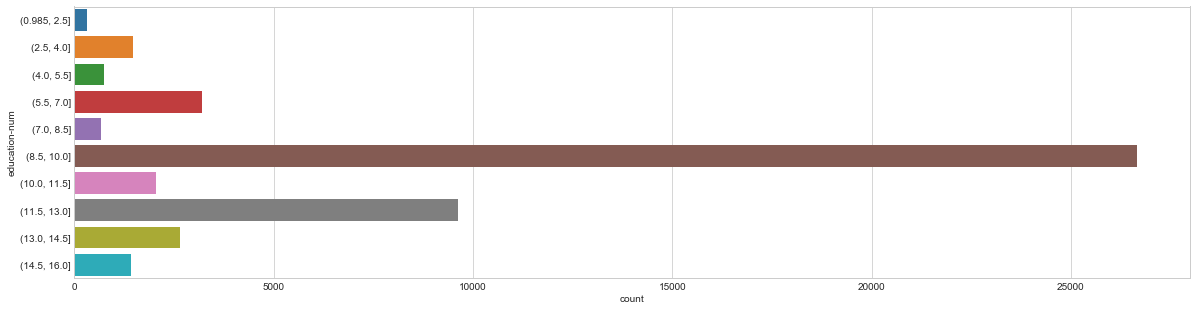

In [34]:
# 教育等级分箱
dataset_bin['education-num'] = pd.cut(data_raw['education-num'], 10)
dataset_con['education-num'] = data_raw['education-num']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5)) 
sns.countplot(y="education-num", data=dataset_bin);

### 属性: Hours per Week

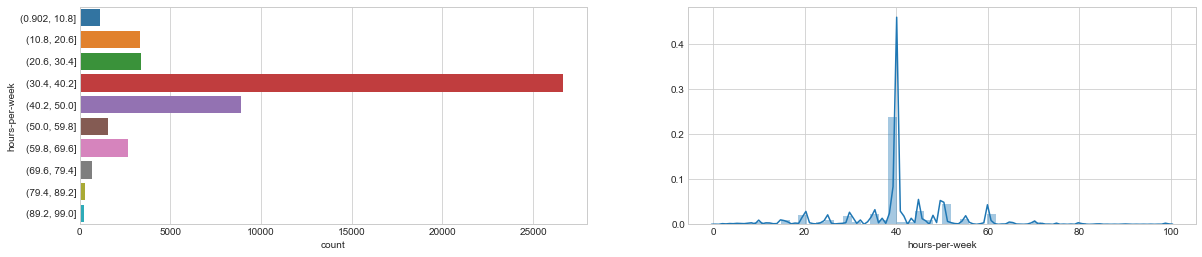

In [35]:
# 周工作时间（小时）分箱
dataset_bin['hours-per-week'] = pd.cut(data_raw['hours-per-week'], 10)
dataset_con['hours-per-week'] = data_raw['hours-per-week']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,4)) 
plt.subplot(1, 2, 1)
# 分箱前
sns.countplot(y="hours-per-week", data=dataset_bin);
plt.subplot(1, 2, 2)
# 分箱后
sns.distplot(dataset_con['hours-per-week']);

### 属性: Capital Gain

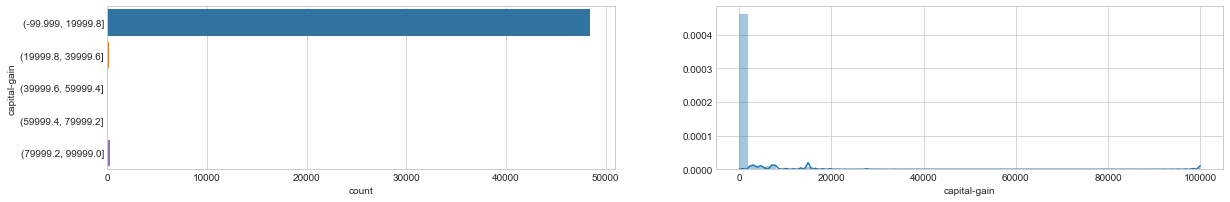

In [36]:
dataset_bin['capital-gain'] = pd.cut(data_raw['capital-gain'], 5)
dataset_con['capital-gain'] = data_raw['capital-gain']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
plt.subplot(1, 2, 1)
sns.countplot(y="capital-gain", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['capital-gain'])

### 属性: Capital Loss

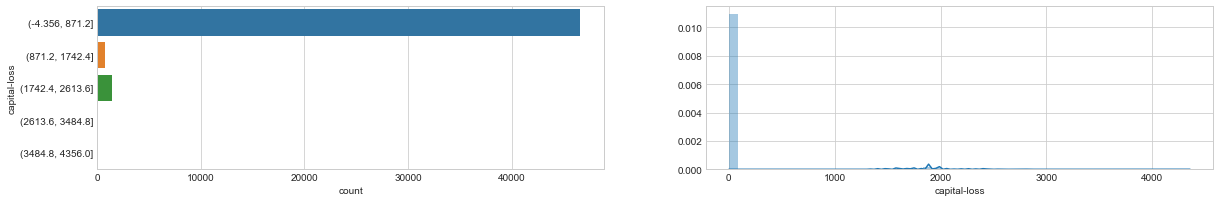

In [37]:
dataset_bin['capital-loss'] = pd.cut(data_raw['capital-loss'], 5)
dataset_con['capital-loss'] = data_raw['capital-loss']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,3)) 
plt.subplot(1, 2, 1)
sns.countplot(y="capital-loss", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con['capital-loss'])

### 属性: Race, Sex, Relationship

In [38]:
# 无需处理
dataset_con['sex'] = dataset_bin['sex'] = data_raw['sex']
dataset_con['race'] = dataset_bin['race'] = data_raw['race']
dataset_con['relationship'] = dataset_bin['relationship'] = data_raw['relationship']

## 属性衍生: Age + Hours Per Week

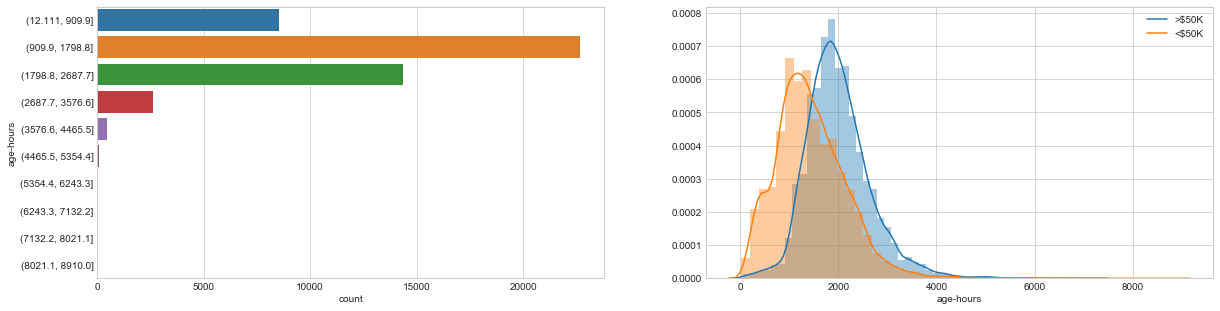

In [39]:
dataset_con['age-hours'] = dataset_con['age'] * dataset_con['hours-per-week']

dataset_bin['age-hours'] = pd.cut(dataset_con['age-hours'], 10)
dataset_con['age-hours'] = dataset_con['age-hours']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5)) 
plt.subplot(1, 2, 1)
sns.countplot(y="age-hours", data=dataset_bin);
plt.subplot(1, 2, 2)
sns.distplot(dataset_con.loc[dataset_con['salary'] == 1]['age-hours'], kde_kws={"label": ">$50K"});
sns.distplot(dataset_con.loc[dataset_con['salary'] == 0]['age-hours'], kde_kws={"label": "<$50K"});

,salary,age,workclass,occupation,native-country,education,marital-status,fnlwgt,education-num,hours-per-week,capital-gain,capital-loss,sex,race,relationship,age-hours,sex-marital
0,0,"(38.9, 46.2]",Non-fed-gov,Admin,United-States,Bachelors,Never-Married,"(10806.885, 160096.5]","(11.5, 13.0]","(30.4, 40.2]","(-99.999, 19999.8]","(-4.356, 871.2]",Male,White,Not-in-family,"(909.9, 1798.8]",MaleNever-Married
1,0,"(46.2, 53.5]",Self-emp,Office Labour,United-States,Bachelors,Married,"(10806.885, 160096.5]","(11.5, 13.0]","(10.8, 20.6]","(-99.999, 19999.8]","(-4.356, 871.2]",Male,White,Husband,"(12.111, 909.9]",MaleMarried
2,0,"(31.6, 38.9]",Private,Manual Labour,United-States,HS-grad,Separated,"(160096.5, 307908.0]","(8.5, 10.0]","(30.4, 40.2]","(-99.999, 19999.8]","(-4.356, 871.2]",Male,White,Not-in-family,"(909.9, 1798.8]",MaleSeparated
3,0,"(46.2, 53.5]",Private,Manual Labour,United-States,Dropout,Married,"(160096.5, 307908.0]","(5.5, 7.0]","(30.4, 40.2]","(-99.999, 19999.8]","(-4.356, 871.2]",Male,Black,Husband,"(1798.8, 2687.7]",MaleMarried
4,0,"(24.3, 31.6]",Private,Professional,South-America,Bachelors,Married,"(307908.0, 455719.5]","(11.5, 13.0]","(30.4, 40.2]","(-99.999, 19999.8]","(-4.356, 871.2]",Female,Black,Wife,"(909.9, 1798.8]",FemaleMarried


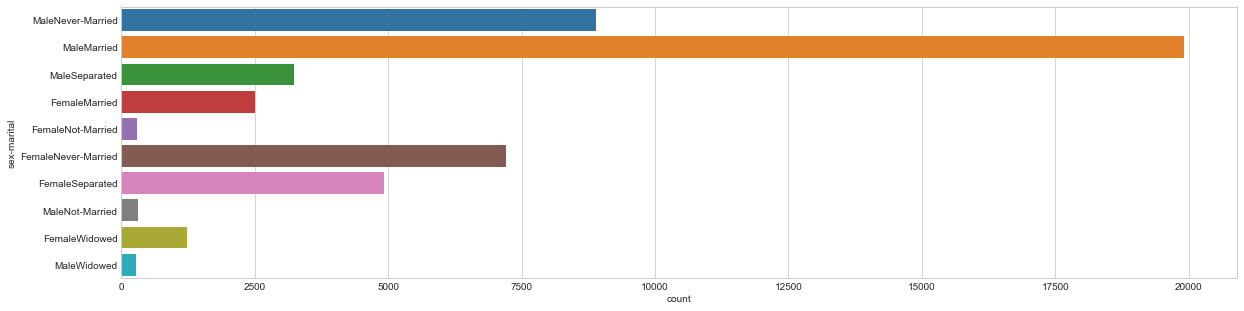

In [40]:
# 标量衍生
dataset_bin['sex-marital'] = dataset_con['sex-marital'] = dataset_con['sex'] + dataset_con['marital-status']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5)) 
sns.countplot(y="sex-marital", data=dataset_bin);
dataset_bin.head()

## 属性编码

* 机器学习算法接收的是数字型变量。
* 把字符型编码为数字型的过程叫做编码
* 我们用到的：
    * 1.One-Hot 
    * 2.Label encoding.

In [41]:
# 所有变量进行One-Hot编码（离散）
one_hot_cols = dataset_bin.columns.tolist()
one_hot_cols.remove('salary')
# One-Hot编码
dataset_bin_enc = pd.get_dummies(dataset_bin, columns=one_hot_cols)

dataset_bin_enc.head()

,salary,"age_(16.927, 24.3]","age_(24.3, 31.6]","age_(31.6, 38.9]","age_(38.9, 46.2]","age_(46.2, 53.5]","age_(53.5, 60.8]","age_(60.8, 68.1]","age_(68.1, 75.4]","age_(75.4, 82.7]",...,sex-marital_FemaleMarried,sex-marital_FemaleNever-Married,sex-marital_FemaleNot-Married,sex-marital_FemaleSeparated,sex-marital_FemaleWidowed,sex-marital_MaleMarried,sex-marital_MaleNever-Married,sex-marital_MaleNot-Married,sex-marital_MaleSeparated,sex-marital_MaleWidowed
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [42]:
# 转换为连续型数字变量
encoder = LabelEncoder()
dataset_con = dataset_con.astype(str)
dataset_con_enc = dataset_con.apply(encoder.fit_transform)

dataset_con_enc.head(20)

,salary,age,workclass,occupation,native-country,education,marital-status,fnlwgt,education-num,hours-per-week,capital-gain,capital-loss,sex,race,relationship,age-hours,sex-marital
0,0,22,1,0,7,1,1,26905,4,34,35,0,1,4,1,252,6
1,0,33,4,3,7,1,0,27243,4,4,0,0,1,4,0,1268,5
2,0,21,3,1,7,5,3,13364,15,34,0,0,1,4,1,237,8
3,0,36,3,1,7,3,0,15068,13,34,0,0,1,2,0,481,5
4,0,11,3,4,6,1,0,21239,4,34,0,0,0,2,5,60,0
5,0,20,3,3,7,6,0,18488,5,34,0,0,0,4,5,221,0
6,0,32,3,5,6,3,2,6159,11,7,0,0,0,2,1,1341,2
7,1,35,4,3,7,5,0,12747,15,39,0,0,1,4,0,567,5
8,1,14,3,4,7,6,1,24463,5,45,13,0,0,4,1,247,1
9,1,25,3,3,7,1,0,6065,4,34,96,0,1,4,0,302,5


## 属性降维/选择（做减法）

原因：正确、效率。

- **降维:**
    - **Principal Component Analysis (PCA)** 
    - **Singular Value Decomposition (SVD)** 

- **选择（重要性）:**
    - **过滤:** 过滤方法仅根据一般度量标准选择要素，例如与要预测的变量的相关性。 过滤方法抑制最不感兴趣的变量。其他变量将是用于分类或预测数据的分类或回归模型的一部分。 这些方法在计算时间方面特别有效，并且对过度拟合具有鲁棒性。
    - **包装:** 包装方法评估变量子集，与过滤器方法不同，它允许检测变量之间可能的相互作用。 这些方法的两个主要缺点是：1.当观测数量不足时，过度拟合风险增加；2.变量数量很大时的显着计算时间。
    - **嵌入式:** 嵌入式方法试图结合两种先前方法的优点。 学习算法利用其自己的变量选择过程并同时执行特征选择和分类。

### 属性相关性

相关性衡量两个随机变量一起变化的程度。 
期望：属性应该彼此不相关，并且与我们试图预测的目标高度相关。

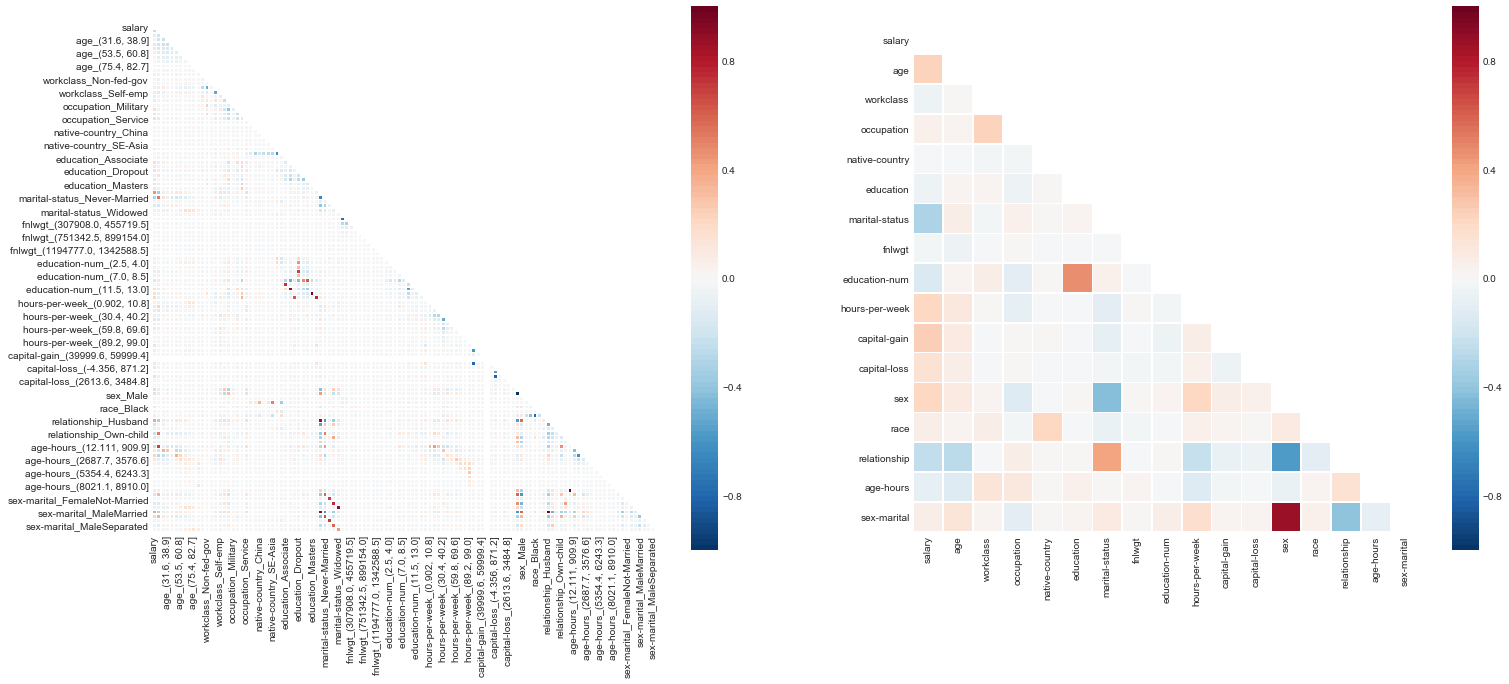

In [43]:
# 绘制两个数据集的关系图.
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25,10)) 

plt.subplot(1, 2, 1)
# 关系热力图
mask = np.zeros_like(dataset_bin_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_bin_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

plt.subplot(1, 2, 2)
mask = np.zeros_like(dataset_con_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_con_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);

### Feature Importance

随机森林

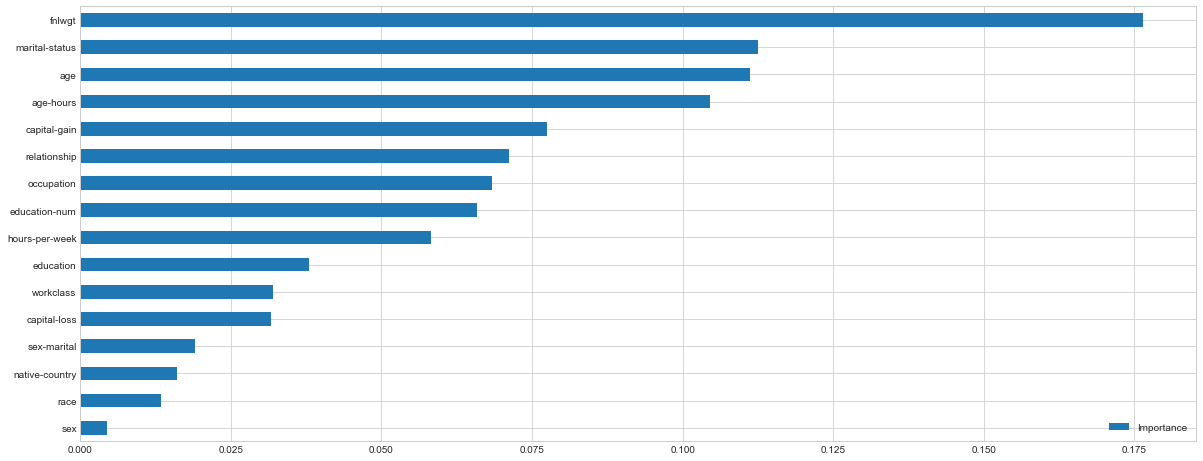

In [44]:
# 使用随机森林算法去查看属性重要性
clf = RandomForestClassifier()
clf.fit(dataset_con_enc.drop('salary', axis=1), dataset_con_enc['salary'])

plt.style.use('seaborn-whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=dataset_con_enc.drop('salary', axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

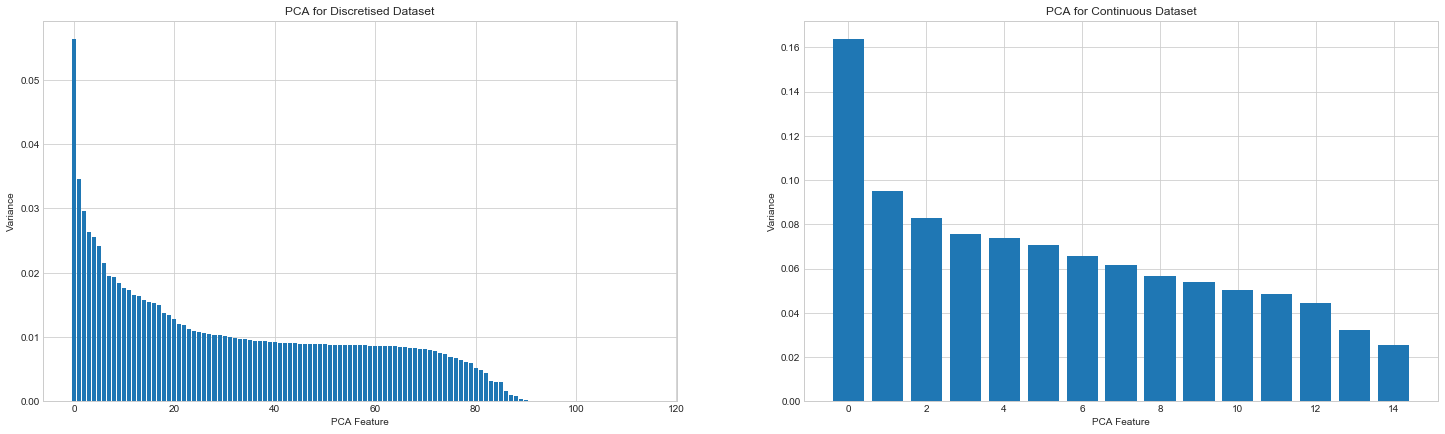

In [45]:
# 计算PCA并绘制方差
std_scale = preprocessing.StandardScaler().fit(dataset_bin_enc.drop('salary', axis=1))
X = std_scale.transform(dataset_bin_enc.drop('salary', axis=1))
pca1 = PCA(n_components=len(dataset_bin_enc.columns)-1)
fit1 = pca1.fit(X)

std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('salary', axis=1))
X = std_scale.transform(dataset_con_enc.drop('salary', axis=1))
pca2 = PCA(n_components=len(dataset_con_enc.columns)-2)
fit2 = pca2.fit(X)

# 绘制每个属性的方差
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(25,7)) 

plt.subplot(1, 2, 1)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Discretised Dataset')
plt.bar(range(0, fit1.explained_variance_ratio_.size), fit1.explained_variance_ratio_);

plt.subplot(1, 2, 2)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Continuous Dataset')
plt.bar(range(0, fit2.explained_variance_ratio_.size), fit2.explained_variance_ratio_);

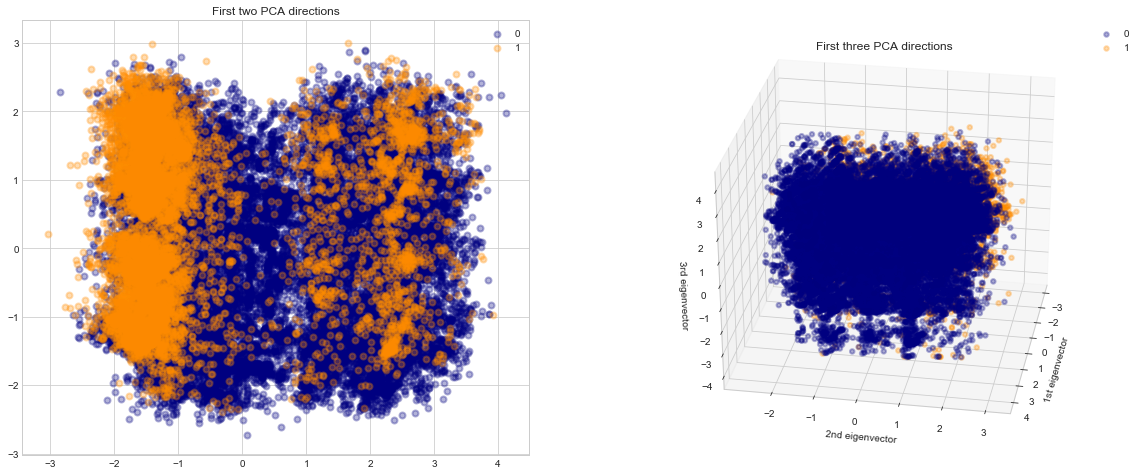

In [46]:
# PCA元素的二维、三维显示
std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('salary', axis=1))
X = std_scale.transform(dataset_con_enc.drop('salary', axis=1))
y = dataset_con_enc['salary']

# 格式
target_names = [0,1]
colors = ['navy','darkorange']
lw = 2
alpha = 0.3
# 2个最优属性
plt.style.use('seaborn-whitegrid')
plt.figure(2, figsize=(20, 8))

plt.subplot(1, 2, 1)
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], 
                color=color, 
                alpha=alpha, 
                lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('First two PCA directions');

# 3个最优属性
ax = plt.subplot(1, 2, 2, projection='3d')

pca = PCA(n_components=3)
X_reduced = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], X_reduced[y == i, 2], 
               color=color,
               alpha=alpha,
               lw=lw, 
               label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# 三维旋转
ax.view_init(30, 10)

## 选择你要的数据集

我们现在有两个数据集可供选择以应用我们的ML算法。 one-hot-encoded和label-encoded。 （以下不进行特征选择）

In [47]:
# 可选的数据集: 
# - dataset_bin_enc（离散编码后）
# - dataset_con_enc（连续编码后）

# 都进行机器学习，最后对比效果

selected_dataset = dataset_con_enc

In [48]:
selected_dataset.head(2)

,salary,age,workclass,occupation,native-country,education,marital-status,fnlwgt,education-num,hours-per-week,capital-gain,capital-loss,sex,race,relationship,age-hours,sex-marital
0,0,22,1,0,7,1,1,26905,4,34,35,0,1,4,1,252,6
1,0,33,4,3,7,1,0,27243,4,4,0,0,1,4,0,1268,5


## 划分 训练集 & 测试集

因为~我们一开始合并了

In [49]:
# 拆分训练集和测试集
train = selected_dataset.loc[0:32560,:]
test = selected_dataset.loc[32560:,:]

### 去除缺失值

In [50]:
# 适用（缺失值数目比较少） -->如果多了呢？
train = train.dropna(axis=0)
test = test.dropna(axis=0)

### 算法开始之前重命名属性和目标

In [51]:
X_train_w_label = train
X_train = train.drop(['salary'], axis=1)
y_train = train['salary'].astype('int64')
X_test  = test.drop(['salary'], axis=1)
y_test  = test['salary'].astype('int64')

In [52]:
X_train.shape

(32561, 16)

In [53]:
X_train.head()

,age,workclass,occupation,native-country,education,marital-status,fnlwgt,education-num,hours-per-week,capital-gain,capital-loss,sex,race,relationship,age-hours,sex-marital
0,22,1,0,7,1,1,26905,4,34,35,0,1,4,1,252,6
1,33,4,3,7,1,0,27243,4,4,0,0,1,4,0,1268,5
2,21,3,1,7,5,3,13364,15,34,0,0,1,4,1,237,8
3,36,3,1,7,3,0,15068,13,34,0,0,1,2,0,481,5
4,11,3,4,6,1,0,21239,4,34,0,0,0,2,5,60,0


In [54]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: salary, dtype: int64

### 选择算法

以下是用到的算法.

- KNN
- Logistic Regression
- Random Forest
- Naive Bayes
- Stochastic Gradient Decent
- Linear SVC
- Decision Tree
- Gradient Boosted Trees

In [55]:
# 绘制ROC曲线
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [56]:
# 训练模型，并输出预测结果
def fit_ml_algo(algo, X_train, y_train, X_test, cv):
    # 训练
    model = algo.fit(X_train, y_train)
    # 预测
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression, 
                          KNeighborsClassifier, 
                          GaussianNB, 
                          DecisionTreeClassifier, 
                          RandomForestClassifier,
                          GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2) 
    # 交叉验证
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1) # 所有CPU核
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    return train_pred, test_pred, acc, acc_cv, probs

In [57]:
# 逻辑回归（随机选择最优参数）

# 输出最佳参数的统一方法
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# 设置参数
param_dist = {'penalty': ['l2', 'l1'], 
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000), 
                         'intercept_scaling': np.logspace(-20, 20, 10000)}

# 随机选取参数
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc, 
                                   n_jobs=-1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 9.80 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.805 (std: 0.003)
Parameters: {'penalty': 'l2', 'intercept_scaling': 53.7245785511047, 'class_weight': None, 'C': 378929.0105015995}

Model with rank: 2
Mean validation score: 0.802 (std: 0.003)
Parameters: {'penalty': 'l2', 'intercept_scaling': 4.6597952751413447e-17, 'class_weight': None, 'C': 7.98160459109945}

Model with rank: 3
Mean validation score: 0.789 (std: 0.001)
Parameters: {'penalty': 'l1', 'intercept_scaling': 4.227295489767881, 'class_weight': None, 'C': 0.0005619206179607351}

Model with rank: 4
Mean validation score: 0.759 (std: 0.000)
Parameters: {'penalty': 'l2', 'intercept_scaling': 1.7853574187293162e+17, 'class_weight': None, 'C': 3857.9681315249372}

Model with rank: 4
Mean validation score: 0.759 (std: 0.000)
Parameters: {'penalty': 'l2', 'intercept_scaling': 79.10242888878624, 'class_weight': None, 'C': 4.2088399998283324e-19}

Model with rank: 

In [58]:
# 训练
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(LogisticRegression(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 80.7
Accuracy CV 10-Fold: 80.19
Running Time: 0:00:07.936003


In [59]:
print(metrics.classification_report(y_train, train_pred_log) )

             precision    recall  f1-score   support

          0       0.83      0.93      0.88     24720
          1       0.64      0.40      0.49      7841

avg / total       0.78      0.80      0.78     32561



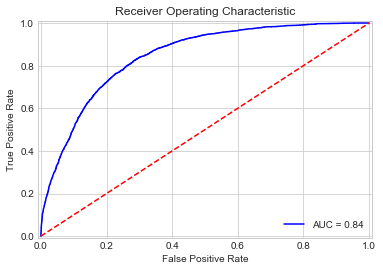

In [60]:
plot_roc_curve(y_test, probs_log)

In [61]:
# KNN
start_time = time.time()
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn = fit_ml_algo(KNeighborsClassifier(n_neighbors = 3,
                                                                                                 n_jobs = -1), 
                                                                                                 X_train, 
                                                                                                 y_train, 
                                                                                                 X_test, 
                                                                                                 10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 73.37
Accuracy CV 10-Fold: 73.06
Running Time: 0:00:06.798867


In [62]:
print (metrics.classification_report(y_train, train_pred_knn) )

             precision    recall  f1-score   support

          0       0.79      0.87      0.83     24720
          1       0.42      0.29      0.34      7841

avg / total       0.70      0.73      0.71     32561



In [63]:
print (metrics.classification_report(y_test, test_pred_knn) )

             precision    recall  f1-score   support

          0       0.80      0.87      0.83     12435
          1       0.41      0.29      0.34      3847

avg / total       0.71      0.73      0.72     16282



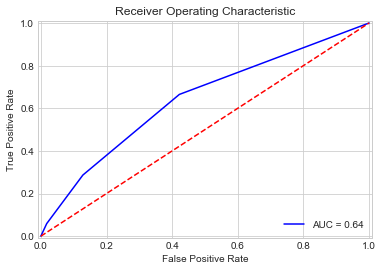

In [64]:
plot_roc_curve(y_test, probs_knn)

In [66]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, test_pred_gaussian, acc_gaussian, acc_cv_gaussian, probs_gau = fit_ml_algo(GaussianNB(), 
                                                                                     X_train, 
                                                                                     y_train, 
                                                                                     X_test, 
                                                                                     10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 81.11
Accuracy CV 10-Fold: 81.03
Running Time: 0:00:06.361202


In [67]:
print (metrics.classification_report(y_train, train_pred_gaussian) )

             precision    recall  f1-score   support

          0       0.86      0.89      0.88     24720
          1       0.62      0.56      0.58      7841

avg / total       0.80      0.81      0.81     32561



In [68]:
print( metrics.classification_report(y_test, test_pred_gaussian) )

             precision    recall  f1-score   support

          0       0.87      0.89      0.88     12435
          1       0.61      0.56      0.58      3847

avg / total       0.81      0.81      0.81     16282



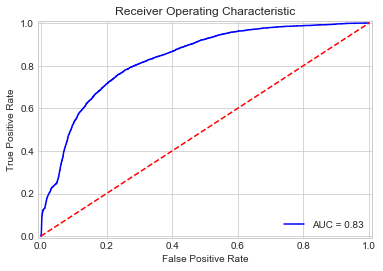

In [69]:
plot_roc_curve(y_test, probs_gau)

In [70]:
# Linear SVC
start_time = time.time()
train_pred_svc, test_pred_svc, acc_linear_svc, acc_cv_linear_svc, _ = fit_ml_algo(LinearSVC(),
                                                                                           X_train, 
                                                                                           y_train,
                                                                                           X_test, 
                                                                                           10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 24.9
Accuracy CV 10-Fold: 66.21
Running Time: 0:00:35.106895


In [71]:
print (metrics.classification_report(y_train, train_pred_svc) )

             precision    recall  f1-score   support

          0       0.78      0.77      0.78     24720
          1       0.31      0.33      0.32      7841

avg / total       0.67      0.66      0.67     32561



In [72]:
print (metrics.classification_report(y_test, test_pred_svc)) 

             precision    recall  f1-score   support

          0       0.88      0.02      0.04     12435
          1       0.24      0.99      0.38      3847

avg / total       0.73      0.25      0.12     16282



In [73]:
# 决策树
start_time = time.time()
train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 80.93
Accuracy CV 10-Fold: 80.49
Running Time: 0:00:06.740634


In [74]:
print (metrics.classification_report(y_train, train_pred_dt) )

             precision    recall  f1-score   support

          0       0.87      0.87      0.87     24720
          1       0.59      0.61      0.60      7841

avg / total       0.81      0.80      0.81     32561



In [75]:
print (metrics.classification_report(y_test, test_pred_dt) )

             precision    recall  f1-score   support

          0       0.88      0.87      0.87     12435
          1       0.59      0.62      0.61      3847

avg / total       0.81      0.81      0.81     16282



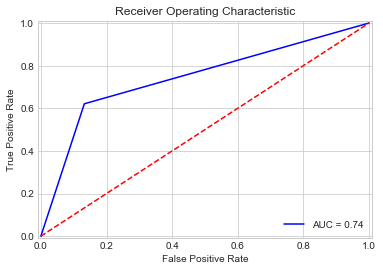

In [76]:
plot_roc_curve(y_test, probs_dt)

In [77]:
# 随机森林

# 输出参数得分
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# 设置参数范围
param_dist = {"max_depth": [10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# 随机搜索
n_iter_search = 10
rfc = RandomForestClassifier(n_estimators=10)
random_search = RandomizedSearchCV(rfc, 
                                   n_jobs = -1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 9.37 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.857 (std: 0.004)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 19}

Model with rank: 2
Mean validation score: 0.856 (std: 0.004)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 8, 'min_samples_leaf': 4, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.856 (std: 0.003)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 17}

Model with rank: 4
Mean validation score: 0.855 (std: 0.003)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 9, 'min_samples_split': 8}

Model with rank: 5
Mean validation score: 0.854 (std: 0.003)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_d

In [78]:
# 训练
start_time = time.time()
rfc = RandomForestClassifier(n_estimators=10, 
                             min_samples_leaf=2,
                             min_samples_split=17, 
                             criterion='gini', 
                             max_features=8)
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_ml_algo(rfc, 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 85.35
Accuracy CV 10-Fold: 85.19
Running Time: 0:00:08.339925


In [79]:
print(metrics.classification_report(y_train, train_pred_rf) )

             precision    recall  f1-score   support

          0       0.88      0.93      0.90     24720
          1       0.73      0.61      0.66      7841

avg / total       0.85      0.85      0.85     32561



In [80]:
print( metrics.classification_report(y_test, test_pred_rf) )

             precision    recall  f1-score   support

          0       0.89      0.93      0.91     12435
          1       0.72      0.61      0.66      3847

avg / total       0.85      0.85      0.85     16282



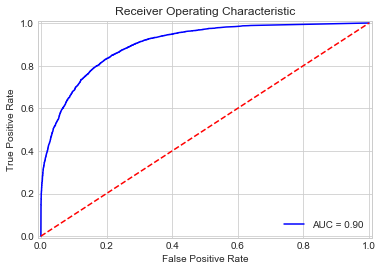

In [81]:
plot_roc_curve(y_test, probs_rf)

In [82]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.42
Accuracy CV 10-Fold: 86.24
Running Time: 0:00:15.282780


In [83]:
print(metrics.classification_report(y_train, train_pred_gbt) )

             precision    recall  f1-score   support

          0       0.88      0.94      0.91     24720
          1       0.78      0.60      0.68      7841

avg / total       0.86      0.86      0.86     32561



In [84]:
print( metrics.classification_report(y_test, test_pred_gbt) )

             precision    recall  f1-score   support

          0       0.89      0.94      0.91     12435
          1       0.77      0.61      0.68      3847

avg / total       0.86      0.86      0.86     16282



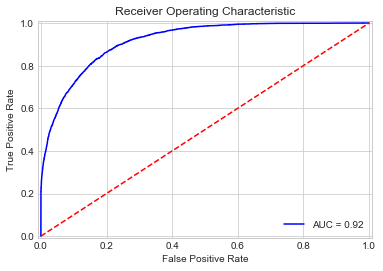

In [85]:
plot_roc_curve(y_test, probs_gbt)

In [86]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
             'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_knn, 
        acc_log, 
        acc_rf, 
        acc_gaussian,  
        acc_linear_svc, 
        acc_dt,
        acc_gbt
    ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
6,Gradient Boosting Trees,86.42
2,Random Forest,85.35
3,Naive Bayes,81.11
5,Decision Tree,80.93
1,Logistic Regression,80.70
0,KNN,73.37
4,Linear SVC,24.90


In [87]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,     
        acc_cv_rf, 
        acc_cv_gaussian, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt
    ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
6,Gradient Boosting Trees,86.24
2,Random Forest,85.19
3,Naive Bayes,81.03
5,Decision Tree,80.49
1,Logistic Regression,80.19
0,KNN,73.06
4,Linear SVC,66.21


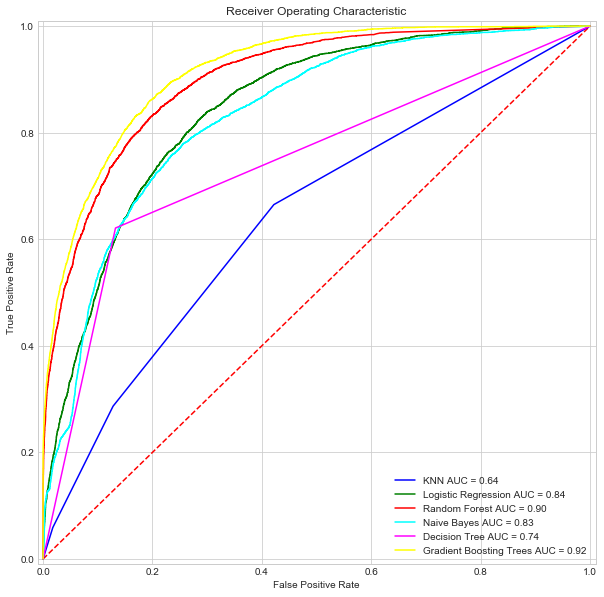

In [88]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10)) 

models = [
    'KNN', 
    'Logistic Regression', 
    'Random Forest', 
    'Naive Bayes', 
    'Decision Tree', 
    'Gradient Boosting Trees'
]
probs = [
    probs_knn,
    probs_log,
    probs_rf,
    probs_gau,
    probs_dt,
    probs_gbt
]
colors = [
    'blue',
    'green',
    'red',
    'cyan',
    'magenta',
    'yellow',
]
    
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

def plot_roc_curves(y_test, prob, model):
    fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = model + ' AUC = %0.2f' % roc_auc, color=colors[i])
    plt.legend(loc = 'lower right')
    
for i, model in list(enumerate(models)):
    plot_roc_curves(y_test, probs[i], models[i])
    
plt.show()